<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/GAN/DCGAN_Cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN (Deep Convolutional Generative Adversarial Network)


## Import and Config

In [1]:
!pip install -q --upgrade albumentations==0.5.1

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

## Define Model

In [22]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class Generator(nn.Module):
    def __init__(self, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Generator, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(100, (in_height // 16) * (in_width // 16) * dim * 8, bias=False),
            Reshape(dim * 8, in_height // 16, in_width // 16),
            nn.BatchNorm2d(dim * 8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 8, dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 4, dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim * 2, dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim, in_channel, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self, dim=64, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Discriminator, self).__init__()

        self.module = nn.Sequential(
            nn.Conv2d(in_channel, dim, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim * 2, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim * 2, dim * 4, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(dim * 4, dim * 8, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear((in_height // 16) * (in_width // 16) * dim * 8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.module(x)


# Dataset

In [23]:
class Cifar10Dataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [24]:
transforms_train = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [25]:
def show_sample(Xs, show_num=8, name="input"):
    Xs = Xs.detach().cpu().numpy().transpose(0, 2, 3, 1)
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(name)
        plt.axis('off')
        
    plt.show()

In [26]:
def train():
    train_models = []
    train_model_paths = []

    EPOCH = 100
        
    train_losses_d = []
    train_losses_g = []
        
    #---
    # datasert
    #---
    batch_size = 256

    train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
    train_Xs = train_ds.data.astype(np.float32)
    train_ys = np.array(train_ds.targets)

    dataset_train = Cifar10Dataset(train_Xs, train_ys, transforms=transforms_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)

    train_n = len(dataloader_train)

    #---
    # model
    #---
    gen = Generator().to(device)
    dis = Discriminator().to(device)

    criterion = nn.BCELoss()
    opt_d = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.9))
    opt_g = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.9))

    #---
    # epoch
    #---
    for epoch in range(EPOCH):
        gen.train()
        dis.train()
        
        tr_loss_d = 0
        tr_loss_g = 0
        total = 0
        
        #---
        # train
        #---
        train_time_start = time.time()
        
        for step, batch in enumerate(dataloader_train):
            opt_d.zero_grad()
            opt_g.zero_grad()

            xs = batch[0].to(device)

            _batch_size = len(xs)

            ones = torch.ones([_batch_size, 1]).to(device)
            zeros = torch.zeros([_batch_size, 1]).to(device)

            #---
            # update discriminator
            #---

            # real x
            y_real = dis(xs)
            loss_real = criterion(y_real, ones)

            # fake x
            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs)
            y_fake = dis(x_fake)
            loss_fake = criterion(y_fake, zeros)
            loss_d = loss_real + loss_fake

            loss_d.backward()
            opt_d.step()

            #---
            # update generator
            #--- 
            opt_d.zero_grad()
            opt_g.zero_grad()

            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs)
            y_fake = dis(x_fake)
            loss_g = criterion(y_fake, ones)
            loss_g.backward()
            opt_g.step()

            tr_loss_d += loss_d.item() / train_n
            tr_loss_g += loss_g.item() / train_n

        train_losses_d.append(tr_loss_d)
        train_losses_g.append(tr_loss_g)

        train_time_end = time.time()

        train_time_total = train_time_end - train_time_start
            
        print(f"epoch:{epoch + 1}/{EPOCH} [tra]loss-d:{tr_loss_d:.4f} loss-g:{tr_loss_g:.4f} [time]tra:{train_time_total:.2f}sec")

        if (epoch + 1) % 100 == 0:
            savename = f"model_epoch{epoch + 1}_{EPOCH}.pth"
            torch.save(gen.state_dict(), savename)
            print(f"model saved to >> {savename}")

        if (epoch + 1) % 20 == 0:
            show_sample(x_fake, name="output")

    #---
    # save model
    #---
    savename = f"model_epoch{EPOCH}.pth"
    torch.save(gen.state_dict(), savename)
    print(f"model saved to >> {savename}")
    print()
    
    train_models.append(gen)
    train_model_paths.append(savename)
    

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.grid()
    ax1.plot(train_losses_d, marker=".", markersize=6, color="red", label="train loss d")
    ax1.plot(train_losses_g, marker=".", markersize=6, color="blue", label="train loss g")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    ax1.set(xlabel="Epoch", ylabel="Loss")
    plt.show()

        
    return train_models, train_model_paths


Files already downloaded and verified
epoch:1/100 [tra]loss-d:0.8074 loss-g:2.5145 [time]tra:76.04sec
epoch:2/100 [tra]loss-d:1.0662 loss-g:1.6662 [time]tra:75.27sec
epoch:3/100 [tra]loss-d:1.1054 loss-g:1.4550 [time]tra:75.50sec
epoch:4/100 [tra]loss-d:1.2204 loss-g:1.1804 [time]tra:75.58sec
epoch:5/100 [tra]loss-d:1.1651 loss-g:1.3316 [time]tra:75.59sec
epoch:6/100 [tra]loss-d:1.0594 loss-g:1.4596 [time]tra:75.56sec
epoch:7/100 [tra]loss-d:1.0356 loss-g:1.6089 [time]tra:75.52sec
epoch:8/100 [tra]loss-d:1.0862 loss-g:1.4895 [time]tra:75.56sec
epoch:9/100 [tra]loss-d:1.1574 loss-g:1.3348 [time]tra:75.56sec
epoch:10/100 [tra]loss-d:1.1564 loss-g:1.3780 [time]tra:75.59sec
epoch:11/100 [tra]loss-d:1.1598 loss-g:1.3791 [time]tra:75.57sec
epoch:12/100 [tra]loss-d:1.1319 loss-g:1.4043 [time]tra:75.60sec
epoch:13/100 [tra]loss-d:1.1389 loss-g:1.4183 [time]tra:75.60sec
epoch:14/100 [tra]loss-d:1.1643 loss-g:1.2978 [time]tra:75.59sec
epoch:15/100 [tra]loss-d:1.1116 loss-g:1.4570 [time]tra:75.64

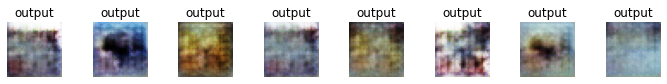

epoch:21/100 [tra]loss-d:0.9493 loss-g:1.9334 [time]tra:75.62sec
epoch:22/100 [tra]loss-d:0.9685 loss-g:1.8682 [time]tra:75.67sec
epoch:23/100 [tra]loss-d:0.9599 loss-g:1.8338 [time]tra:75.60sec
epoch:24/100 [tra]loss-d:1.0045 loss-g:1.8383 [time]tra:75.55sec
epoch:25/100 [tra]loss-d:0.9700 loss-g:1.8682 [time]tra:75.64sec
epoch:26/100 [tra]loss-d:0.8773 loss-g:2.0849 [time]tra:75.91sec
epoch:27/100 [tra]loss-d:0.8690 loss-g:2.1246 [time]tra:75.90sec
epoch:28/100 [tra]loss-d:0.9046 loss-g:2.0435 [time]tra:75.98sec
epoch:29/100 [tra]loss-d:0.8684 loss-g:2.0976 [time]tra:75.78sec
epoch:30/100 [tra]loss-d:0.8419 loss-g:2.2705 [time]tra:75.90sec
epoch:31/100 [tra]loss-d:0.8547 loss-g:2.2869 [time]tra:75.67sec
epoch:32/100 [tra]loss-d:0.8366 loss-g:2.3317 [time]tra:75.63sec
epoch:33/100 [tra]loss-d:0.8401 loss-g:2.2338 [time]tra:75.62sec
epoch:34/100 [tra]loss-d:0.8177 loss-g:2.2793 [time]tra:75.59sec
epoch:35/100 [tra]loss-d:0.8604 loss-g:2.2703 [time]tra:75.59sec
epoch:36/100 [tra]loss-d:

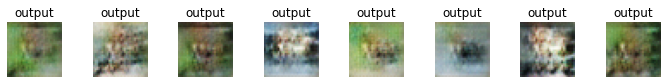

epoch:41/100 [tra]loss-d:0.8579 loss-g:2.2173 [time]tra:75.61sec
epoch:42/100 [tra]loss-d:0.8411 loss-g:2.2879 [time]tra:75.71sec
epoch:43/100 [tra]loss-d:0.8499 loss-g:2.2945 [time]tra:75.69sec
epoch:44/100 [tra]loss-d:0.8256 loss-g:2.3546 [time]tra:75.63sec
epoch:45/100 [tra]loss-d:0.8345 loss-g:2.3525 [time]tra:75.62sec
epoch:46/100 [tra]loss-d:0.8269 loss-g:2.2941 [time]tra:75.62sec
epoch:47/100 [tra]loss-d:0.8413 loss-g:2.3206 [time]tra:75.63sec
epoch:48/100 [tra]loss-d:0.8532 loss-g:2.3506 [time]tra:75.88sec
epoch:49/100 [tra]loss-d:0.7732 loss-g:2.5272 [time]tra:75.97sec
epoch:50/100 [tra]loss-d:0.7238 loss-g:2.6277 [time]tra:75.65sec
epoch:51/100 [tra]loss-d:0.7572 loss-g:2.6381 [time]tra:75.58sec
epoch:52/100 [tra]loss-d:0.7391 loss-g:2.6173 [time]tra:75.62sec
epoch:53/100 [tra]loss-d:0.7491 loss-g:2.5333 [time]tra:75.59sec
epoch:54/100 [tra]loss-d:0.7429 loss-g:2.7851 [time]tra:75.60sec
epoch:55/100 [tra]loss-d:0.6704 loss-g:2.8568 [time]tra:75.89sec
epoch:56/100 [tra]loss-d:

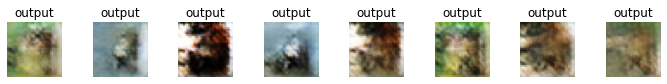

epoch:61/100 [tra]loss-d:0.7200 loss-g:2.8610 [time]tra:75.72sec
epoch:62/100 [tra]loss-d:0.7236 loss-g:2.7917 [time]tra:75.64sec
epoch:63/100 [tra]loss-d:0.6185 loss-g:3.1106 [time]tra:75.60sec
epoch:64/100 [tra]loss-d:0.6618 loss-g:3.0771 [time]tra:75.57sec
epoch:65/100 [tra]loss-d:0.6946 loss-g:3.0281 [time]tra:75.59sec
epoch:66/100 [tra]loss-d:0.7170 loss-g:2.6517 [time]tra:75.83sec
epoch:67/100 [tra]loss-d:0.6750 loss-g:2.8998 [time]tra:75.64sec
epoch:68/100 [tra]loss-d:0.6580 loss-g:2.8786 [time]tra:75.64sec
epoch:69/100 [tra]loss-d:0.6237 loss-g:3.0693 [time]tra:75.59sec
epoch:70/100 [tra]loss-d:0.6254 loss-g:2.9639 [time]tra:75.59sec
epoch:71/100 [tra]loss-d:0.6508 loss-g:2.9940 [time]tra:75.59sec
epoch:72/100 [tra]loss-d:0.6008 loss-g:3.0340 [time]tra:75.75sec
epoch:73/100 [tra]loss-d:0.6517 loss-g:3.4667 [time]tra:75.59sec
epoch:74/100 [tra]loss-d:0.6153 loss-g:3.2632 [time]tra:75.08sec
epoch:75/100 [tra]loss-d:0.6302 loss-g:3.2981 [time]tra:74.65sec
epoch:76/100 [tra]loss-d:

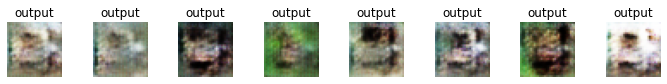

epoch:81/100 [tra]loss-d:0.6396 loss-g:3.1711 [time]tra:74.98sec
epoch:82/100 [tra]loss-d:0.6081 loss-g:3.1803 [time]tra:74.81sec
epoch:83/100 [tra]loss-d:0.6091 loss-g:3.1045 [time]tra:74.86sec
epoch:84/100 [tra]loss-d:0.5635 loss-g:3.2315 [time]tra:75.41sec
epoch:85/100 [tra]loss-d:0.6030 loss-g:3.2060 [time]tra:74.61sec
epoch:86/100 [tra]loss-d:0.6190 loss-g:3.1643 [time]tra:74.63sec
epoch:87/100 [tra]loss-d:0.6581 loss-g:2.9699 [time]tra:74.75sec
epoch:88/100 [tra]loss-d:0.5830 loss-g:3.3594 [time]tra:74.66sec
epoch:89/100 [tra]loss-d:0.5933 loss-g:3.0755 [time]tra:74.65sec
epoch:90/100 [tra]loss-d:0.6044 loss-g:3.1744 [time]tra:74.76sec
epoch:91/100 [tra]loss-d:0.5402 loss-g:3.2483 [time]tra:74.54sec
epoch:92/100 [tra]loss-d:0.6039 loss-g:3.4682 [time]tra:74.01sec
epoch:93/100 [tra]loss-d:0.5753 loss-g:3.3334 [time]tra:73.96sec
epoch:94/100 [tra]loss-d:0.6091 loss-g:3.1617 [time]tra:74.00sec
epoch:95/100 [tra]loss-d:0.5824 loss-g:3.4243 [time]tra:73.91sec
epoch:96/100 [tra]loss-d:

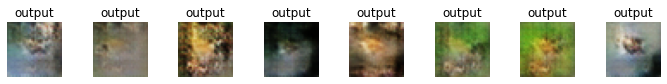

model saved to >> model_epoch100.pth



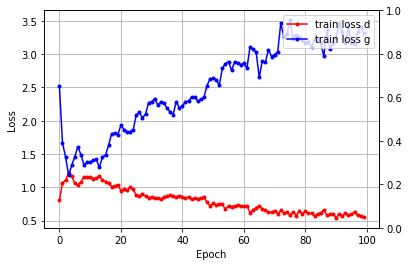

In [27]:
train_models, train_model_paths = train()

# Test

In [ ]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    with torch.no_grad():
        model = train_models[0]

        for _ in range(2):
            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            xs = model(zs)
            show_sample(xs, name="output")

test(train_models)